# Deep Convolutional Generative Adversarial Network (DCGAN) for MNIST Generation

This notebook implements a Deep Convolutional Generative Adversarial Network (DCGAN) to generate synthetic images resembling the MNIST dataset. The key components include:


## Components and Configuration

1. **Generator and Discriminator Models:**
   - The generator utilizes a transposed convolutional layers to transform random noise into synthetic images.
   - The discriminator is also a convolutional layers designed to distinguish between real and generated images.

2. **Training Loop:**
   - The training loop iterates through the MNIST dataset, updating the discriminator and generator in an alternating fashion.
   - Binary Cross Entropy with Logits Loss is employed as the loss criterion for training both the discriminator and generator.

3. **Optimizers:**
   - Adam optimizers are used to update the parameters of the generator and discriminator during training.

4. **Image Visualization:**
   - A function is provided for visualizing the generated and real images during the training process.

5. **MNIST Dataset:**
   - The MNIST dataset is used for training, consisting of 28x28 grayscale images of handwritten digits (0-9).

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

## Image Visualization Function

This function is designed to visually display a grid of images given an input tensor of images. It is particularly useful for visualizing real or generated images during the training of a Generative Adversarial Network (GAN).

### Parameters:
- **image_tensor:** Input tensor of images to be visualized.
- **num_images:** Number of images to be displayed in the grid (default is 25).
- **size:** Size of each image (default is (1, 28, 28) for a 28x28 image with 1 channel).
- **generated:** A flag to determine if the images are generated (default is False).


### Steps:
1. **Preprocessing:**
   - Ensure the input tensor is normalized, detached, moved to CPU..

2. **Grid Arrangement:**
   - Arrange images in a grid using the `make_grid` function, displaying 'num_images' with 5 images per row.

3. **Display:**
   - Display the image grid using matplotlib.
   - Set the title based on the 'generated' flag.
   - Turn off axes to display images only.

4. **Show Image Grid:**
   - Show the image grid using `plt.show()`.

In [2]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28), generated=False):
    '''
    Function for visualizing images in a uniform grid.

    Parameters:
    - image_tensor: Input tensor of images to be visualized.
    - num_images: Number of images to be displayed in the grid (default is 25).
    - size: Size of each image (default is (1, 28, 28) for a 28x28 image with 1 channel).
    - generated: A flag to determine if the images are generated (default is False).

    Comments:
    - The function scales the pixel values of the input tensor to the range [0, 1] for visualization.
    - It then detaches the tensor, moves it to the CPU, and reshapes it for display.
    - The images are arranged in a grid using the make_grid function, with 'num_images' displayed in 5 images per row.
    - The resulting image grid is shown using matplotlib.
    '''
    # Scale pixel values to the range [0, 1]
    image_tensor = (image_tensor + 1) / 2

    # Ensure the tensor is detached, moved to CPU, and reshaped for visualization
    image_unflat = image_tensor.detach().cpu()

    # Arrange images in a grid using the make_grid function, displaying 'num_images' with 5 images per row
    image_grid = make_grid(image_unflat[:num_images], nrow=5)

    # Display the image grid using matplotlib
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    
    # Set title based on the 'generated' flag
    if generated:
        plt.title("Generated Images")
    else:
        plt.title("Real Images")
        
    # Turn off axis to display images only
    plt.axis(False)

    # Show the image grid
    plt.show()

## Generator for Generative Adversarial Network (GAN)

The `Generator` class represents the generator component of a Deep Convolutional Generative Adversarial Network (DCGAN). It takes random noise as input and generates synthetic images.

Here's an overview of the key components:

### Architecture:
- The generator consists of a series of generator blocks, each composed of a transposed convolutional layer, batch normalization, and ReLU activation.
- The number of hidden layers and their dimensions are determined by the `hidden_dim` parameter.
- The final layer is a transposed convolutional layer followed by a hyperbolic tangent (Tanh) activation. Tanh is used to squash the output to the range [-1, 1].

### Initialization:
- The `__init__` method initializes the generator with default or user-specified dimensions for the input noise vector (`z_dim`), output image (`im_chan`), and hidden layers (`hidden_dim`).
- The `make_gen_block` method creates a generator block with a transposed convolutional layer, batch normalization, and ReLU activation.

### Forward Pass:
- The `forward` method defines the forward pass of the generator, taking a noise tensor as input and producing generated images.
- The input noise tensor is reshaped and passed through the sequential blocks defined in the constructor.

### Example usage
generator = Generator(z_dim=100, im_chan=1, hidden_dim=64)
noise_vector = torch.randn((batch_size, 100))  # Generate random noise
generated_images = generator(noise_vector)

In [ ]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN, 
        corresponding to a transposed convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)  # Use ReLU activation for non-linearity
            )
        else:  # Final Layer
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh()  # Use Tanh activation for the final layer to squash the output to the range [-1, 1]
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        noise = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(noise)

## Generating Random Noise for GAN

This function, `get_noise`, serves the purpose of creating random noise vectors, typically used as input for the generator in a GAN. The generated noise vectors are crucial for the GAN training process as they provide the variability necessary for the generator to produce diverse synthetic samples.

### Parameters:
- `n_samples`: The number of noise samples to generate.
- `z_dim`: The dimension of the noise vector.
- `device`: The device where the generated tensor will be allocated, with the default being 'cpu'.

### Example usage
noise = get_noise(n_samples=100, z_dim=64, device='cuda')

In [4]:
def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function to generate random noise for a GAN.

    Parameters:
    - n_samples: The number of noise samples to generate.
    - z_dim: The dimension of the noise vector.
    - device: The device where the tensor will be allocated (default is 'cpu').

    Returns:
    - Random noise tensor with dimensions [n_samples, z_dim] on the specified device.
    '''
    # Generate random noise of shape (n_samples, z_dim) from a normal distribution
    # and allocate it to the specified device (CPU or GPU)
    return torch.randn(n_samples, z_dim).to(device)

## Discriminator for Generative Adversarial Network (GAN)

The `Discriminator` class represents the discriminator component of a Deep Convolutional Generative Adversarial Network (DCGAN). It evaluates input images and classifies them as fake or real.

Here's an overview of the key components:

### Architecture:
- The discriminator consists of a series of discriminator blocks, each composed of a convolutional layer, batch normalization, and LeakyReLU activation.
- The number of hidden layers and their dimensions are determined by the `hidden_dim` parameter.
- The final layer is a convolutional layer without batch normalization.

### Initialization:
- The `__init__` method initializes the discriminator with default or user-specified dimensions for the input image (`im_chan`) and hidden layers (`hidden_dim`).
- The `make_disc_block` method creates a discriminator block with a convolutional layer, batch normalization, and LeakyReLU activation.

### Forward Pass:
- The `forward` method defines the forward pass of the discriminator, taking an image tensor as input and producing a 1-dimensional tensor representing fake or real.

### Example usage
discriminator = Discriminator(im_chan=1, hidden_dim=16)
image_tensor = torch.randn((batch_size, 1, 28, 28))  # Generate random image tensor
discriminator_output = discriminator(image_tensor)

In [5]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
    hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of DCGAN, 
        corresponding to a convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True) 
            )
        else: # Final Layer
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride)
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: image tensor
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

## Training Configuration for Generative Adversarial Network (GAN)

This section outlines the configuration parameters and setup for training a Generative Adversarial Network (GAN) using the MNIST dataset.

### Criterion:
- Binary Cross Entropy with Logits Loss (BCEWithLogitsLoss) is selected as the loss function for both the generator and discriminator.

### Generator Configuration:
- The dimension of the input noise vector for the generator (`z_dim`) is set to 64.

### Training Parameters:
- `display_step`: The frequency for displaying intermediate results during training is set to 500 steps.
- `batch_size`: The batch size for the dataset is configured to be 128.

### Optimizer Parameters:
- Learning rate (`lr`): The learning rate for the Adam optimizer is set to 0.0002.
- Adam optimizer hyperparameters:
  - `beta_1`: Exponential decay rate for the first moment estimate, configured to 0.5.
  - `beta_2`: Exponential decay rate for the second moment estimate, configured to 0.999.

### Device:
- The device for computation is determined based on GPU availability. If available, 'cuda' is selected; otherwise, 'cpu' is the default.

### Image Transformations:
- Image transformations include converting the image to a PyTorch tensor and normalizing tensor values to be in the range [-1, 1] using the tanh activation function.

### DataLoader Setup:
- DataLoader is set up for the MNIST dataset with the specified transformations, batch size, and shuffle option.

In [6]:
# Binary Cross Entropy with Logits Loss criterion
criterion = nn.BCEWithLogitsLoss()

# Dimension of the input noise vector for the generator
z_dim = 64

# Frequency for displaying intermediate results during training
display_step = 500

# Batch size for the dataset
batch_size = 128

# Learning rate for the optimizers
lr = 0.0002

# Adam optimizer hyperparameters
beta_1 = 0.5  # Exponential decay rate for the first moment estimate
beta_2 = 0.999  # Exponential decay rate for the second moment estimate

# Determine and set the device for computation
# Check for GPU availability; use 'cuda' if available, otherwise default to 'cpu'
device = 'cuda'

# Image transformations for normalization
# Transform the image values to be between -1 and 1 (the range of the tanh activation)
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5,), (0.5,)),  # Normalize the tensor values to be in the range [-1, 1]
])

# DataLoader setup for MNIST dataset, downloading if necessary, transforming to tensors
dataloader = DataLoader(
    MNIST('.', download=False, transform=transform),
    batch_size=batch_size,
    shuffle=True
)

## GAN Model and Optimizer Instantiation

In [7]:
# Instantiate Generator and Discriminator models
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# Weight Initialization Function
def weights_init(m):
    '''
    Function to initialize the weights of convolutional and batch normalization layers.

    Parameters:
        m: A module in the neural network.

    Note:
        - Convolutional layers and BatchNormalization layers have their weights initialized.
        - Weights are initialized from a normal distribution with mean 0 and standard deviation 0.02.
        - BatchNormalization biases are initialized to zero.
    '''
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        # Initialize convolutional layer weights
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        # Initialize BatchNormalization layer weights and biases
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

# Apply weight initialization to Generator and Discriminator
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

## Discriminator Loss Computation

This function calculates the discriminator's loss by comparing its predictions for real and generated (fake) images using the Binary Cross Entropy with Logits Loss. The goal is to train the discriminator to distinguish between real and fake images effectively.

### Parameters:
- `gen`: The generator model.
- `disc`: The discriminator model.
- `criterion`: The loss function, typically Binary Cross Entropy with Logits Loss (`nn.BCEWithLogitsLoss()`).
- `real`: Real images from the dataset.
- `num_images`: The number of fake images to generate for the loss computation.
- `z_dim`: The dimension of the noise vector used by the generator.
- `device`: The device on which to perform computations ('cpu' or 'cuda').

### Steps:
1. **Generate Fake Images:**
   - Random noise is generated using the `get_noise` function.
   - The generator uses this noise to produce synthetic (fake) images.

2. **Discriminator Predictions:**
   - The discriminator evaluates the generated fake images (`disc_fake_pred`) and real images (`disc_real_pred`).

3. **Compute Losses:**
   - Binary Cross Entropy with Logits Loss is applied to compare the discriminator's predictions with the ground truth labels (zeros for fake, ones for real).
   - Separate losses are calculated for fake and real images.

4. **Overall Discriminator Loss:**
   - The overall discriminator loss is computed as the average of the losses for fake and real images.

In [8]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    '''
    Function to compute the discriminator's loss in a GAN.

    Parameters:
    - gen: The generator model.
    - disc: The discriminator model.
    - criterion: The loss function.
    - real: Real images from the dataset.
    - num_images: The number of fake images to generate.
    - z_dim: The dimension of the noise vector.
    - device: The device on which to perform the computations (e.g., 'cpu' or 'cuda').

    Returns:
    - The calculated discriminator loss.
    '''
    # Generate fake images from the generator using random noise
    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)

    # Calculate discriminator's predictions for fake and real images
    disc_fake_pred = disc(fake.detach())  # Detach to prevent generator's gradients from updating
    disc_real_pred = disc(real)

    # Compute losses using the provided criterion
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))

    # Calculate the overall discriminator loss as the average of fake and real image losses
    disc_loss = (disc_fake_loss + disc_real_loss) / 2

    return disc_loss

## Generator Loss Computation

This function calculates the generator's loss by comparing the discriminator's predictions for generated (fake) images with the ground truth labels. The goal is to train the generator to produce synthetic images that are more convincing and difficult for the discriminator to distinguish from real ones.

### Parameters:
- `gen`: The generator model.
- `disc`: The discriminator model.
- `criterion`: The loss function, typically Binary Cross Entropy with Logits Loss (`nn.BCEWithLogitsLoss()`).
- `num_images`: The number of fake images to generate for the loss computation.
- `z_dim`: The dimension of the noise vector used by the generator.
- `device`: The device on which to perform computations ('cpu' or 'cuda').

### Steps:
1. **Generate Fake Images:**
   - Random noise is generated using the `get_noise` function.
   - The generator uses this noise to produce synthetic (fake) images.

2. **Discriminator Predictions:**
   - The discriminator evaluates the generated fake images (`disc_fake_pred`).

3. **Compute Generator Loss:**
   - Binary Cross Entropy with Logits Loss is applied to compare the discriminator's predictions with the ground truth labels (ones, indicating that the generator wants the discriminator to classify the generated images as real).

In [9]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    '''
    Function to compute the generator's loss in a GAN.

    Parameters:
    - gen: The generator model.
    - disc: The discriminator model.
    - criterion: The loss function.
    - num_images: The number of fake images to generate for loss calculation.
    - z_dim: The dimension of the noise vector.
    - device: The device on which to perform the computations (e.g., 'cpu' or 'cuda').

    Returns:
    - The calculated generator loss.
    '''
    # Generate fake images from the generator using random noise
    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)

    # Calculate discriminator's predictions for the generated fake images
    disc_fake_pred = disc(fake)

    # Compute generator's loss using the provided criterion
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))

    return gen_loss

## GAN Training Loop

### Initialization:
- `cur_step`, `mean_generator_loss`, and `mean_discriminator_loss` are initialized for tracking and visualization.
- The training loop iterates through the dataset for the specified number of epochs (`n_epochs`).

### Training Steps:
1. **Data Preparation:**
   - Real images are retrieved from the dataset (`dataloader`) and moved to the specified device.

2. **Discriminator Training:**
   - Zero out the gradients for the discriminator's optimizer.
   - Compute the discriminator loss using the `get_disc_loss` function.
   - Perform backpropagation for the discriminator.
   - Update the discriminator's optimizer.

3. **Generator Training:**
   - Zero out the gradients for the generator's optimizer.
   - Compute the generator loss using the `get_gen_loss` function.
   - Perform backpropagation for the generator.
   - Update the generator's optimizer.

4. **Loss Tracking:**
   - Calculate and track the average discriminator and generator losses.
   - Display the losses periodically during training.

5. **Visualization:**
   - Generate fake images using the trained generator.
   - Display both the generated and real images periodically during training.

6. **Step Count and Update:**
   - Update the current step count.

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 500: Generator loss: 0.9583829116821284, discriminator loss: 0.506520387560129


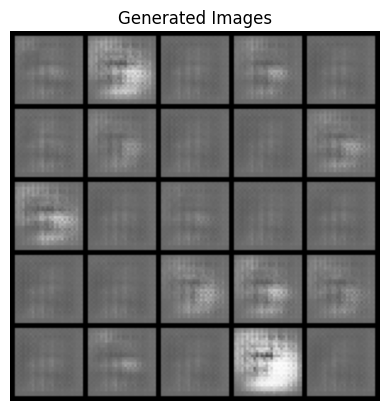

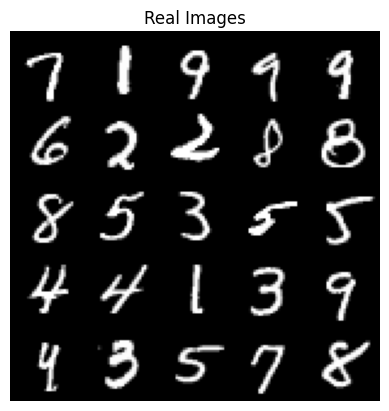

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1000: Generator loss: 1.64302618703246, discriminator loss: 0.37201980173587784


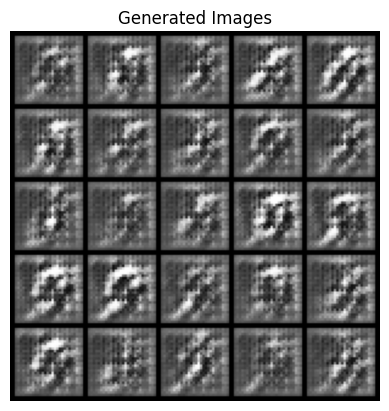

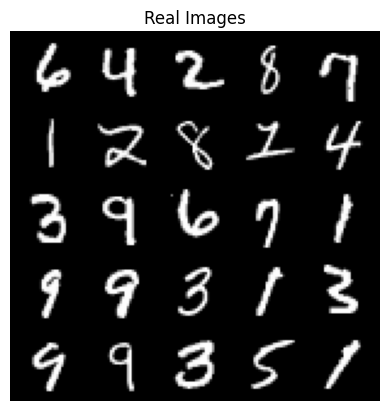

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1500: Generator loss: 1.3327917560637013, discriminator loss: 0.4823097222745423


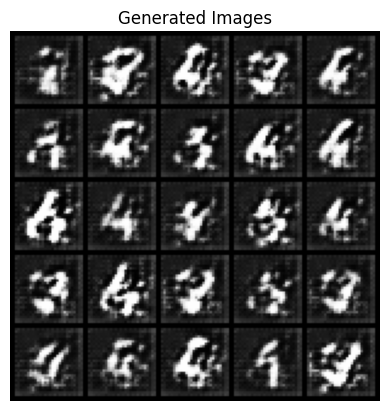

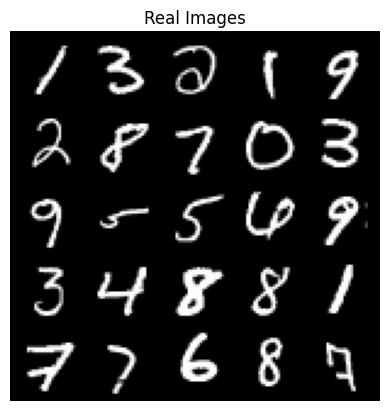

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2000: Generator loss: 1.0008021853566171, discriminator loss: 0.5653658318519593


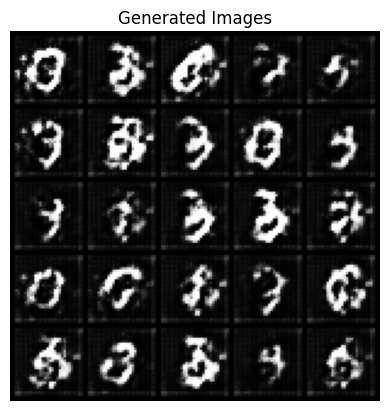

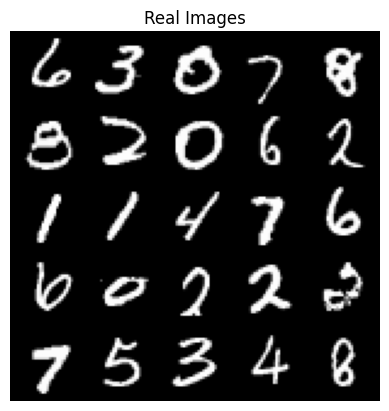

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2500: Generator loss: 0.91798918735981, discriminator loss: 0.5912053519487381


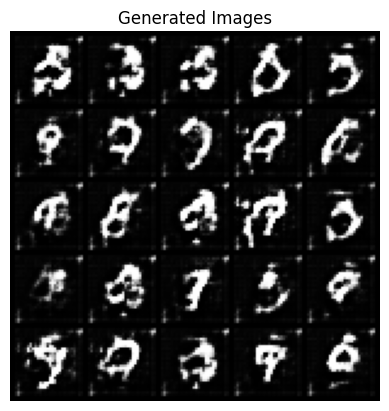

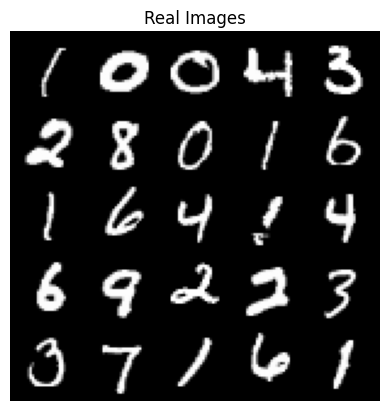

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3000: Generator loss: 0.8353500478863717, discriminator loss: 0.6332064099311827


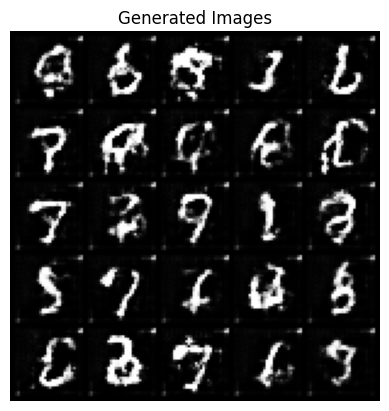

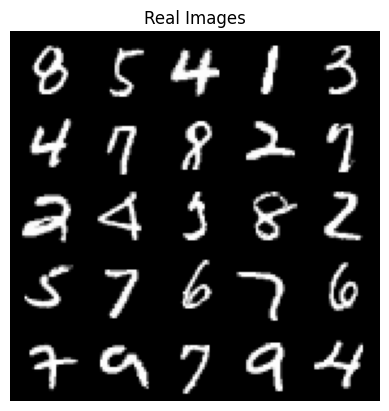

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3500: Generator loss: 0.7912183896303181, discriminator loss: 0.655261081457138


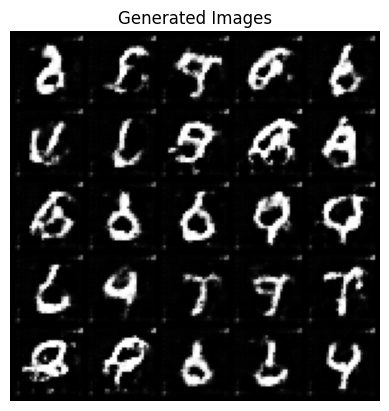

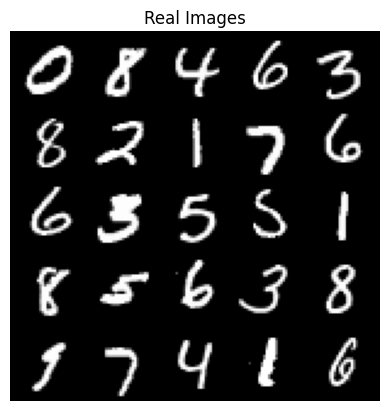

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4000: Generator loss: 0.7784172717332837, discriminator loss: 0.6657533410787582


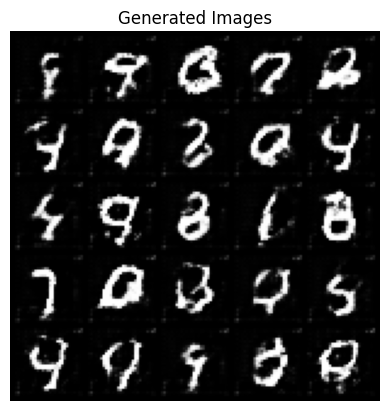

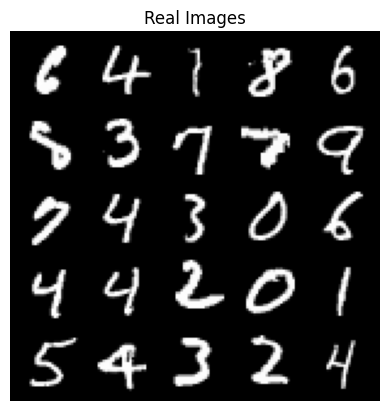

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4500: Generator loss: 0.7451394992470735, discriminator loss: 0.6777559870481492


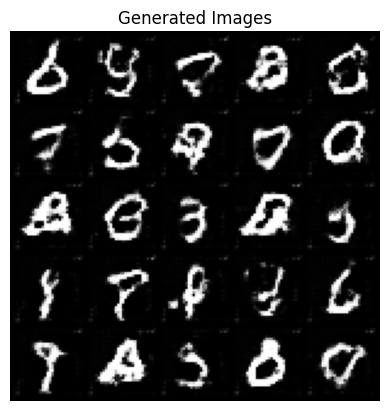

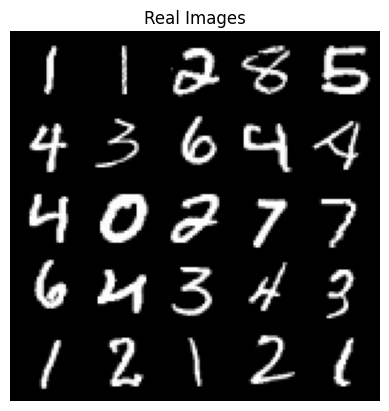

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5000: Generator loss: 0.7529322334527963, discriminator loss: 0.6774368122816079


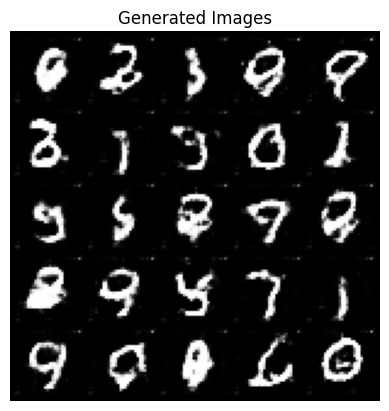

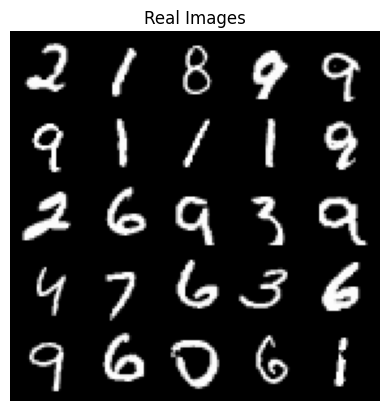

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5500: Generator loss: 0.739553376972675, discriminator loss: 0.6826100839376449


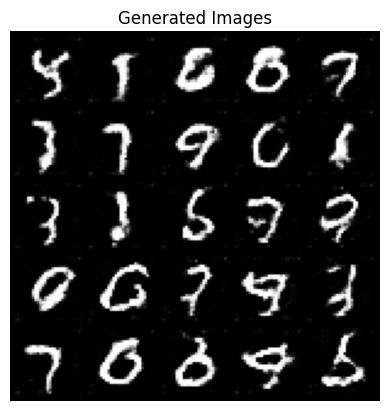

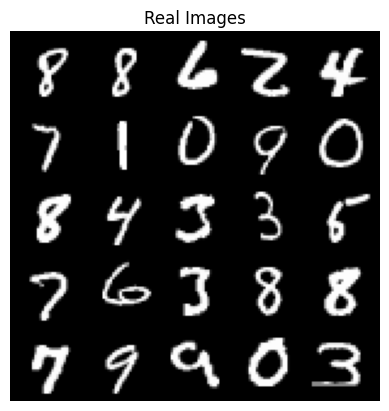

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6000: Generator loss: 0.7340086331963537, discriminator loss: 0.6848123584985726


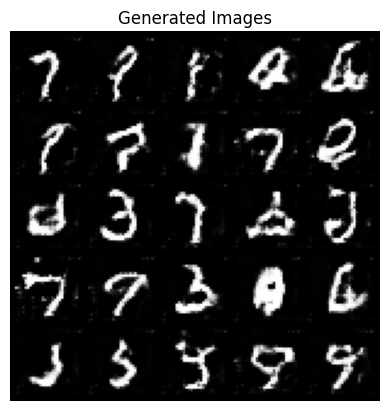

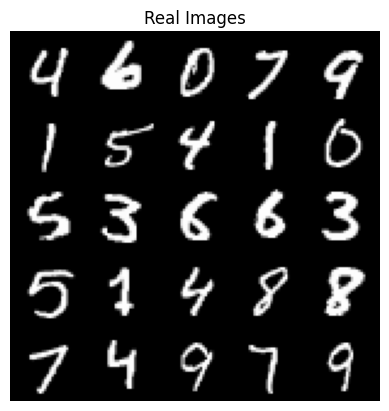

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6500: Generator loss: 0.7374357109665868, discriminator loss: 0.6859746847152715


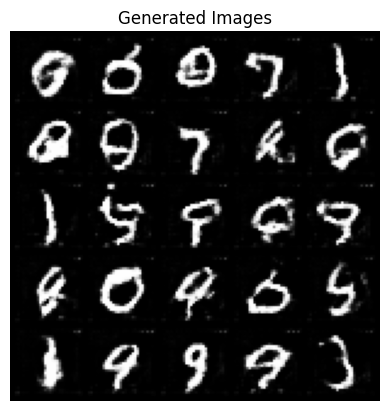

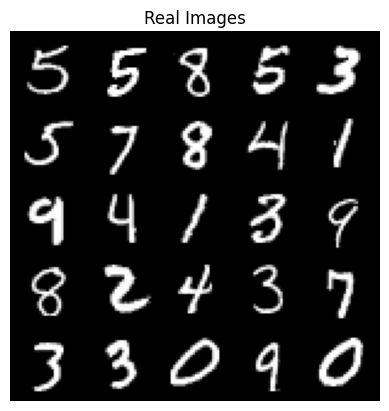

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7000: Generator loss: 0.734162742197514, discriminator loss: 0.6858987234830857


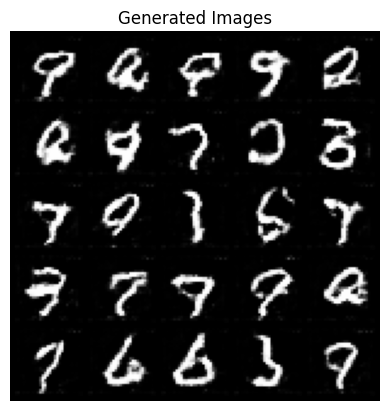

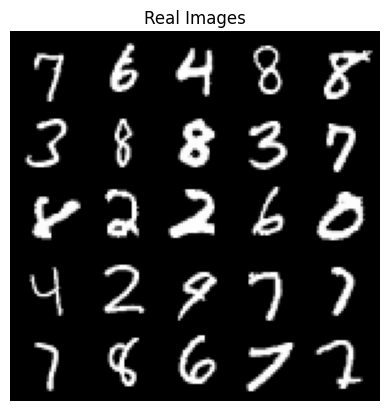

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7500: Generator loss: 0.7344820944666859, discriminator loss: 0.6866215531826021


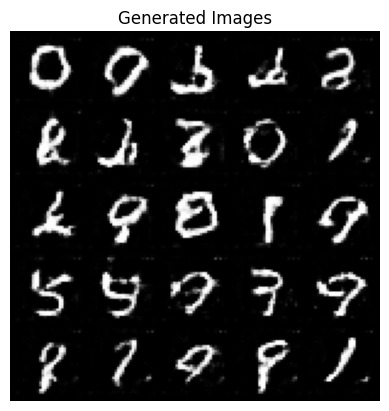

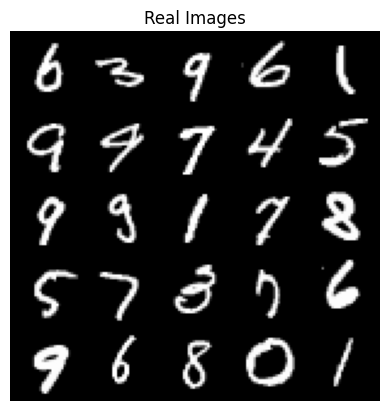

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8000: Generator loss: 0.7274465320110327, discriminator loss: 0.6873898034095762


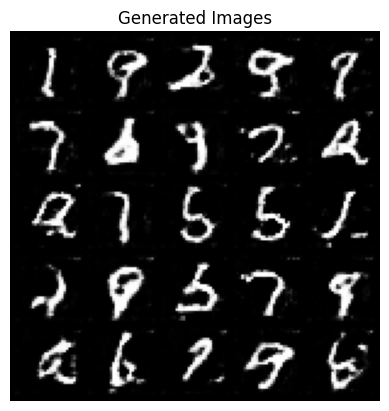

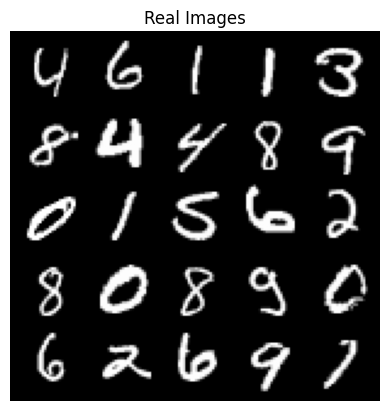

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8500: Generator loss: 0.7195748378634457, discriminator loss: 0.6891064634323121


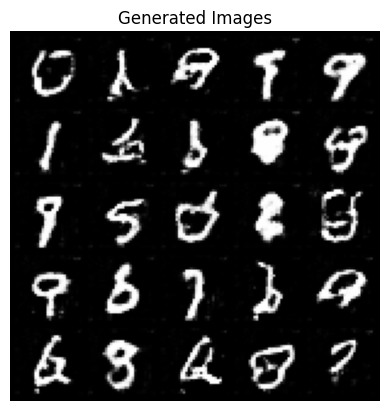

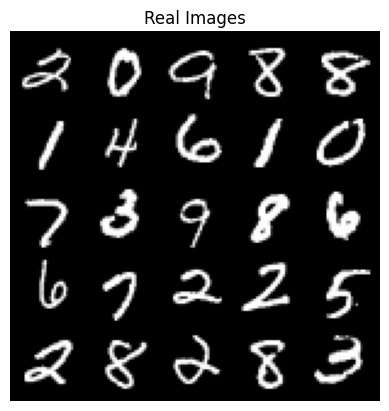

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9000: Generator loss: 0.7224834544658656, discriminator loss: 0.6902083376646038


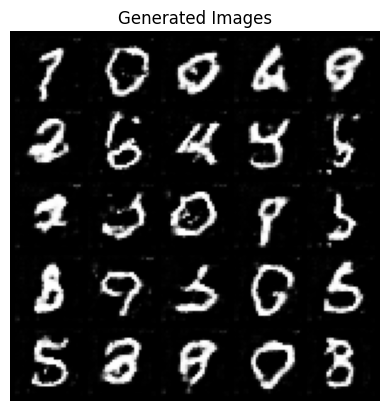

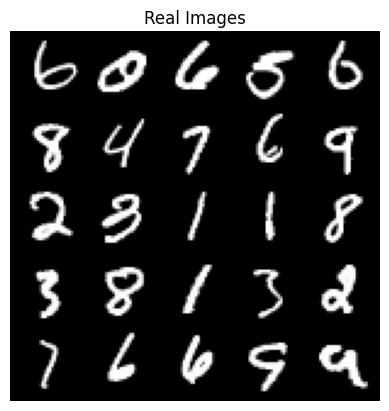

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9500: Generator loss: 0.7241874151825901, discriminator loss: 0.689633417248726


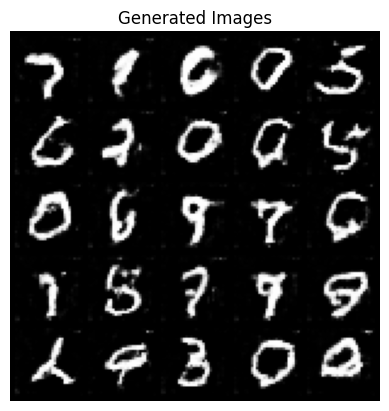

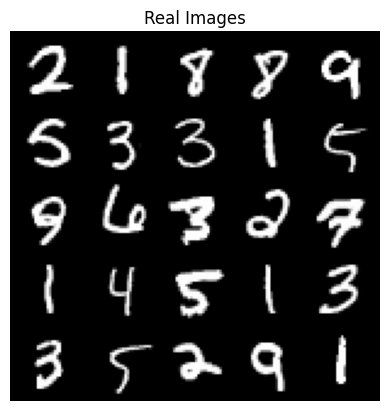

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10000: Generator loss: 0.7201333305239673, discriminator loss: 0.69034440112114


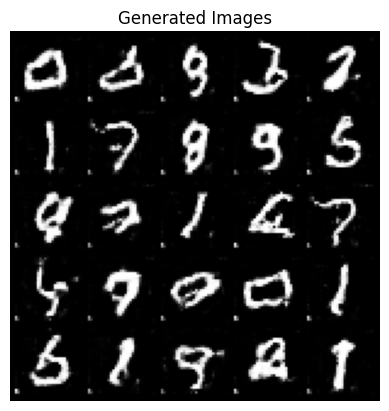

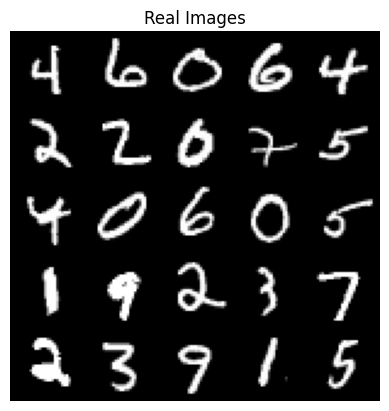

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10500: Generator loss: 0.7149359436631201, discriminator loss: 0.6915905455350883


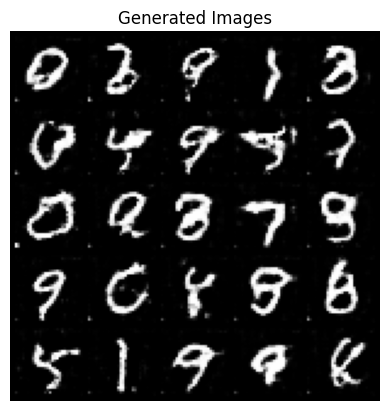

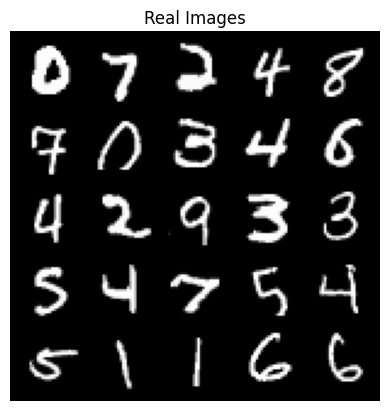

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11000: Generator loss: 0.7137591485977172, discriminator loss: 0.6916758866310118


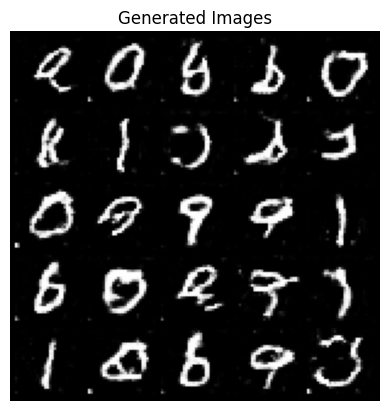

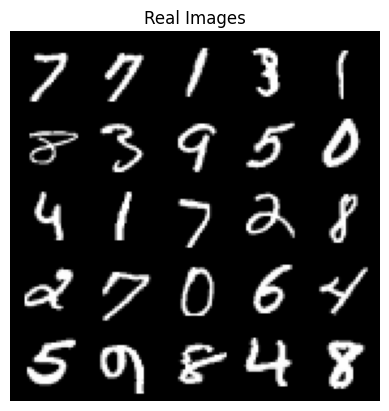

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11500: Generator loss: 0.7128737074136728, discriminator loss: 0.6921706042289737


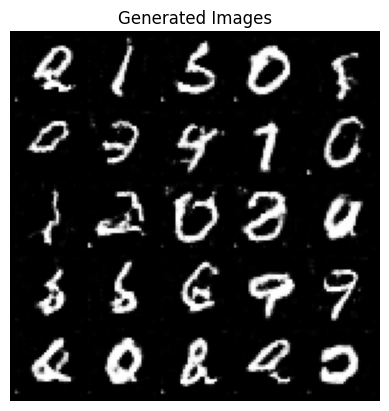

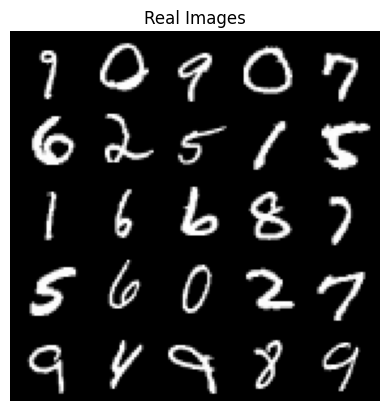

  0%|          | 0/469 [00:00<?, ?it/s]

Step 12000: Generator loss: 0.7128727563619609, discriminator loss: 0.6923053021430975


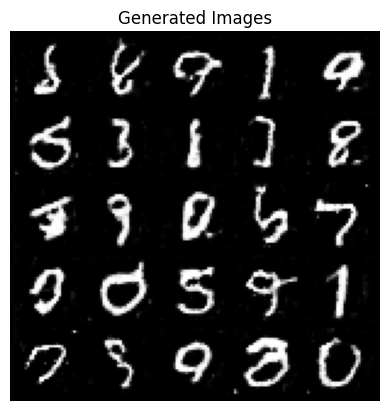

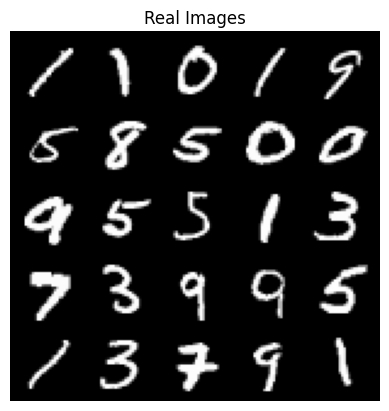

  0%|          | 0/469 [00:00<?, ?it/s]

Step 12500: Generator loss: 0.7120612909197812, discriminator loss: 0.6931964309215541


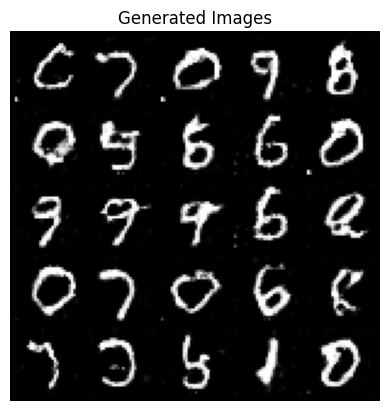

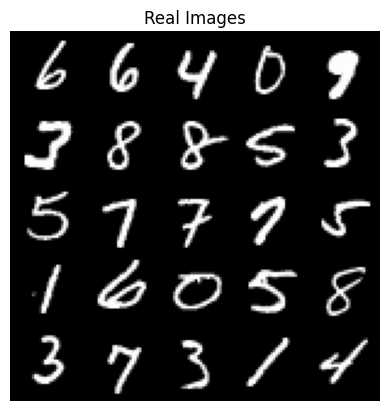

  0%|          | 0/469 [00:00<?, ?it/s]

Step 13000: Generator loss: 0.7102304278016094, discriminator loss: 0.6937627080678944


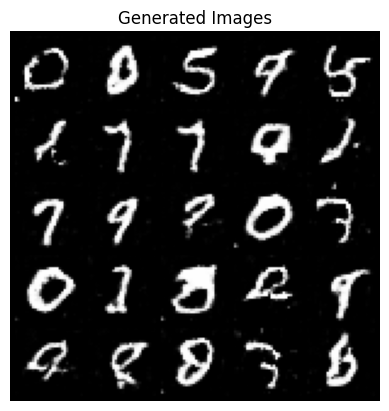

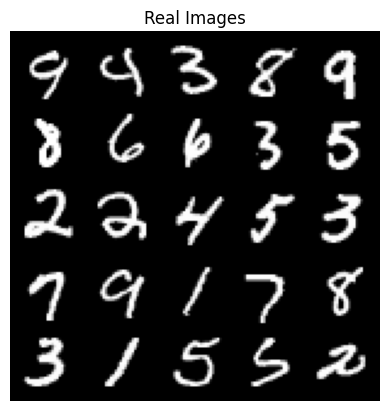

  0%|          | 0/469 [00:00<?, ?it/s]

Step 13500: Generator loss: 0.7088508918285372, discriminator loss: 0.6946160280704502


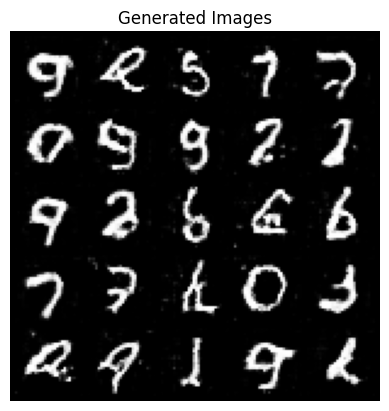

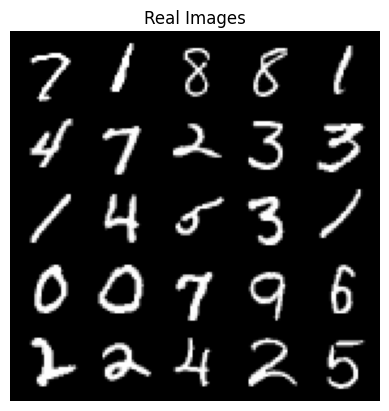

  0%|          | 0/469 [00:00<?, ?it/s]

Step 14000: Generator loss: 0.7095469315648083, discriminator loss: 0.6935537219047546


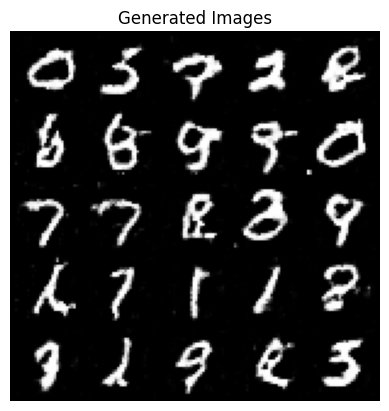

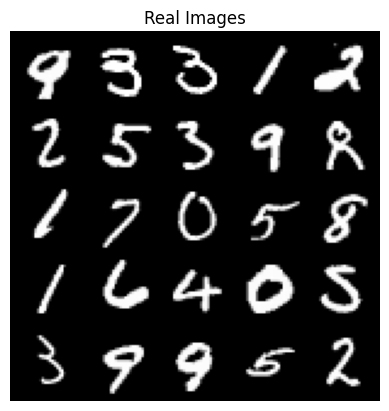

  0%|          | 0/469 [00:00<?, ?it/s]

Step 14500: Generator loss: 0.7078278102874758, discriminator loss: 0.6952685607671747


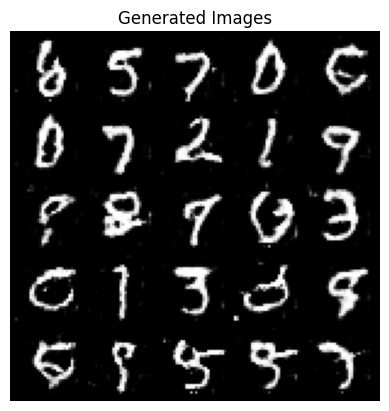

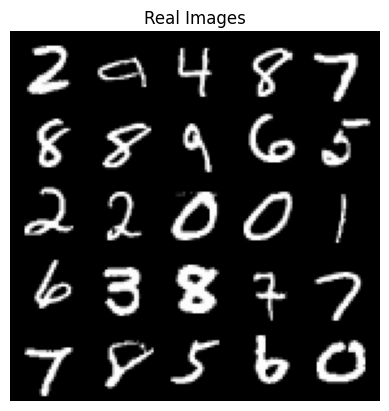

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15000: Generator loss: 0.7079798902273174, discriminator loss: 0.6947526335716248


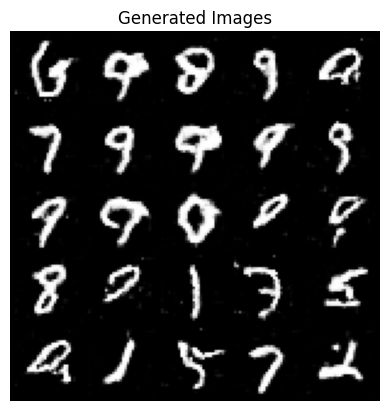

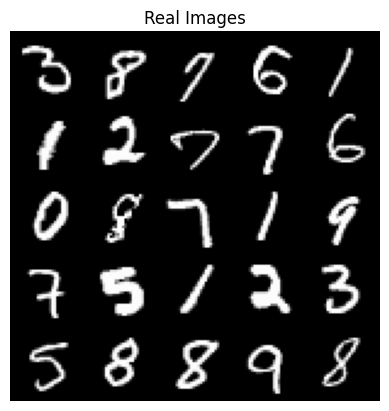

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15500: Generator loss: 0.7064867439270018, discriminator loss: 0.6945779421329503


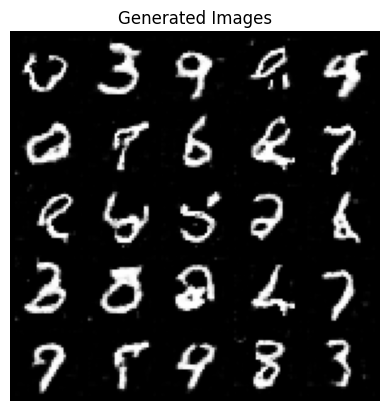

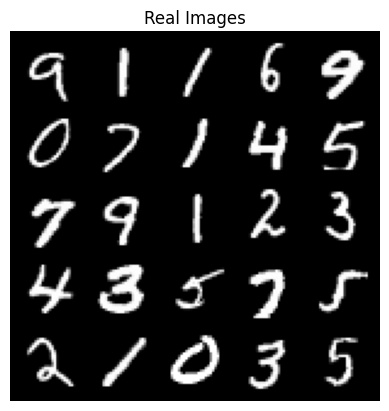

  0%|          | 0/469 [00:00<?, ?it/s]

Step 16000: Generator loss: 0.7050178992748267, discriminator loss: 0.694580204248429


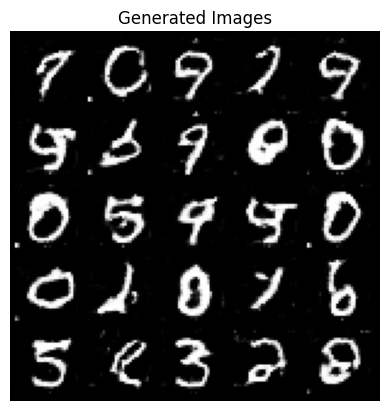

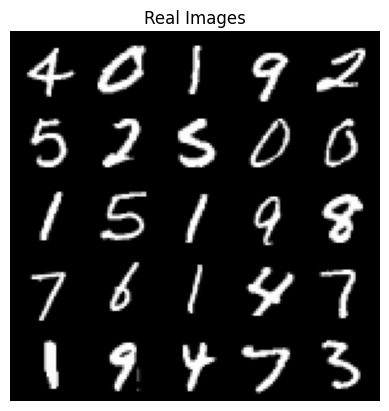

  0%|          | 0/469 [00:00<?, ?it/s]

Step 16500: Generator loss: 0.7041213498115537, discriminator loss: 0.696052210688591


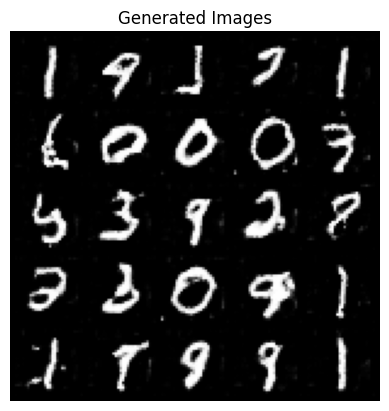

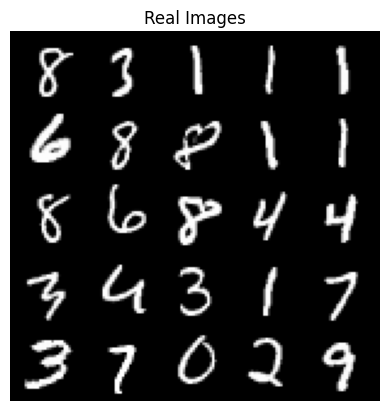

  0%|          | 0/469 [00:00<?, ?it/s]

Step 17000: Generator loss: 0.7040731465220456, discriminator loss: 0.6956640424728391


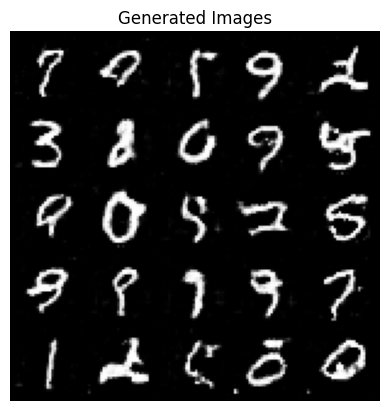

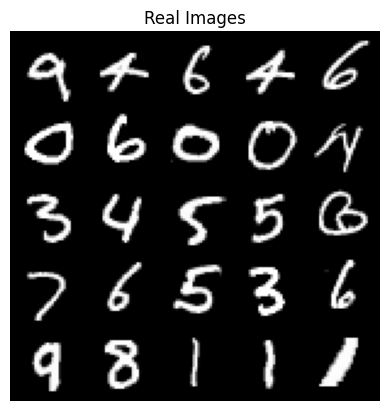

  0%|          | 0/469 [00:00<?, ?it/s]

Step 17500: Generator loss: 0.7016374065876012, discriminator loss: 0.6952744096517558


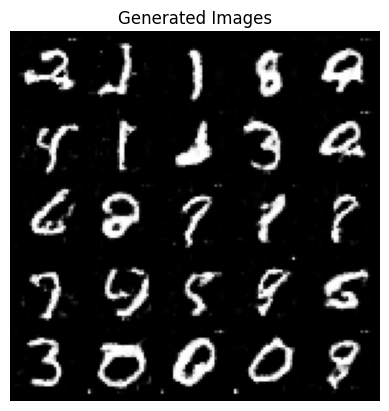

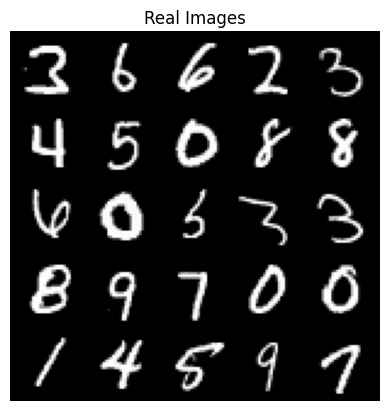

  0%|          | 0/469 [00:00<?, ?it/s]

Step 18000: Generator loss: 0.700730135440826, discriminator loss: 0.6955225367546081


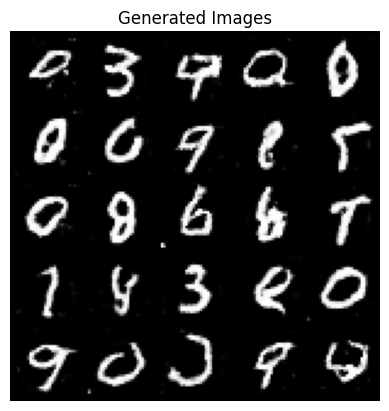

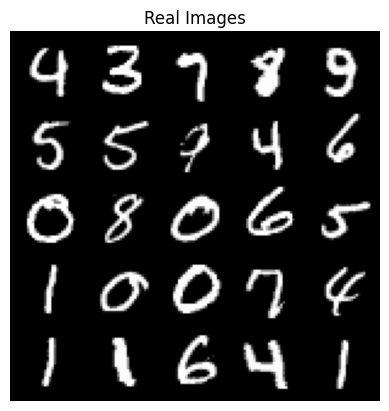

  0%|          | 0/469 [00:00<?, ?it/s]

Step 18500: Generator loss: 0.7005314816236494, discriminator loss: 0.6957021964788445


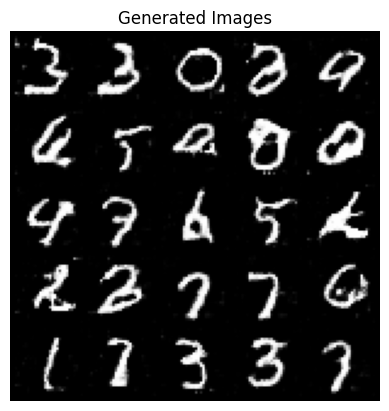

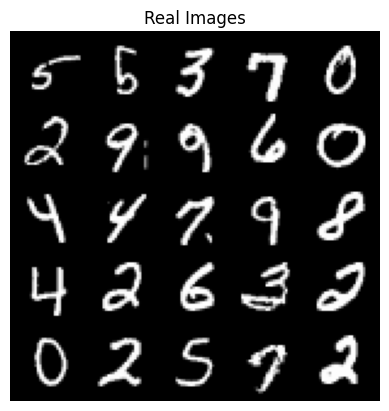

  0%|          | 0/469 [00:00<?, ?it/s]

Step 19000: Generator loss: 0.6996555310487752, discriminator loss: 0.6959441000223153


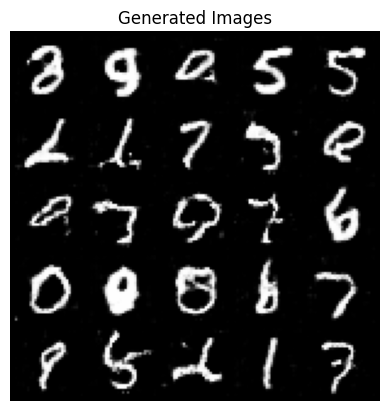

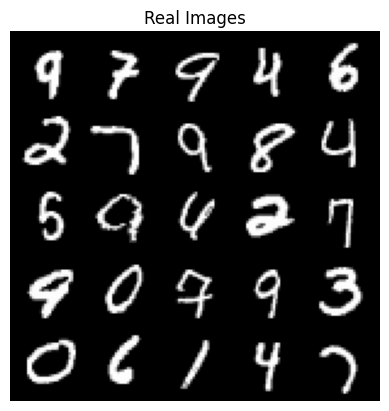

  0%|          | 0/469 [00:00<?, ?it/s]

Step 19500: Generator loss: 0.6989831784963607, discriminator loss: 0.6952739887237549


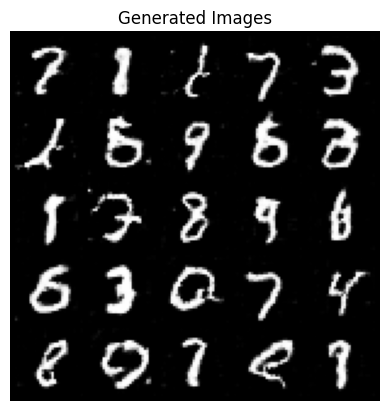

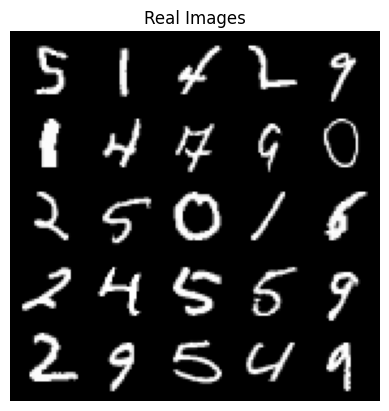

  0%|          | 0/469 [00:00<?, ?it/s]

Step 20000: Generator loss: 0.6988171499967579, discriminator loss: 0.6950715565681453


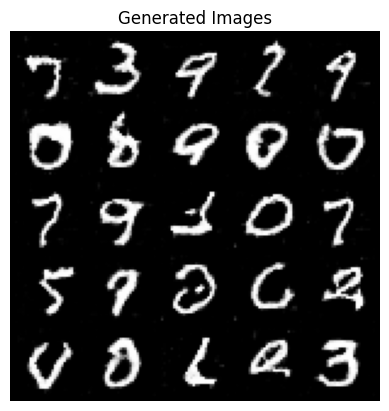

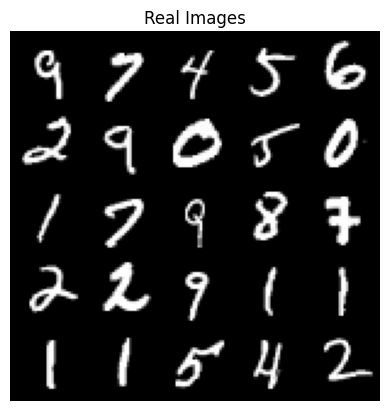

  0%|          | 0/469 [00:00<?, ?it/s]

Step 20500: Generator loss: 0.6993370659351351, discriminator loss: 0.6950267302989969


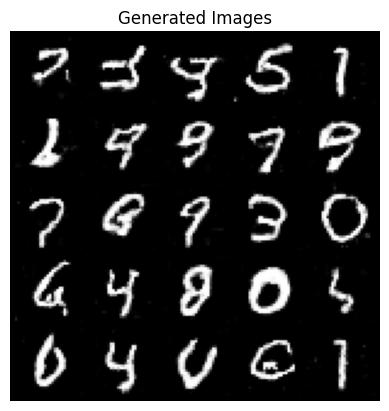

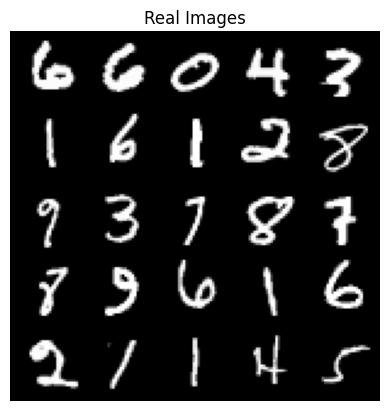

  0%|          | 0/469 [00:00<?, ?it/s]

Step 21000: Generator loss: 0.6986898108720777, discriminator loss: 0.694957815647126


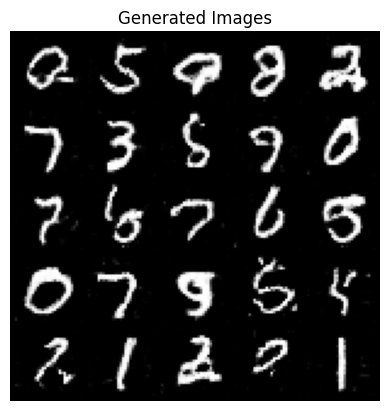

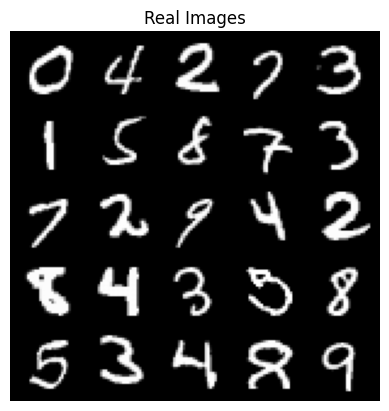

  0%|          | 0/469 [00:00<?, ?it/s]

Step 21500: Generator loss: 0.6988436948060989, discriminator loss: 0.6948325294256215


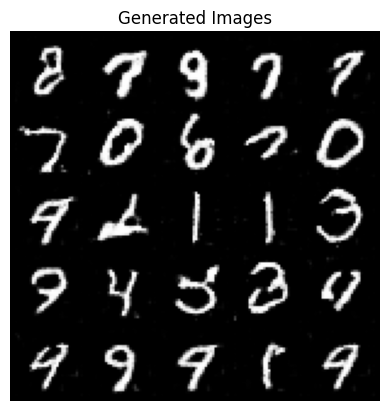

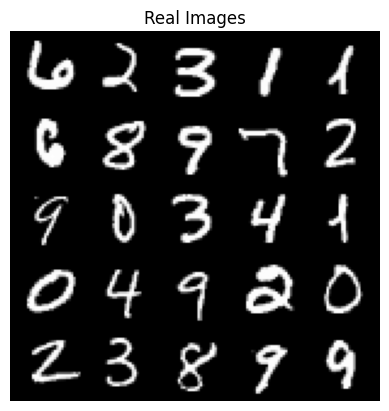

  0%|          | 0/469 [00:00<?, ?it/s]

Step 22000: Generator loss: 0.6973940632343292, discriminator loss: 0.6948069735765459


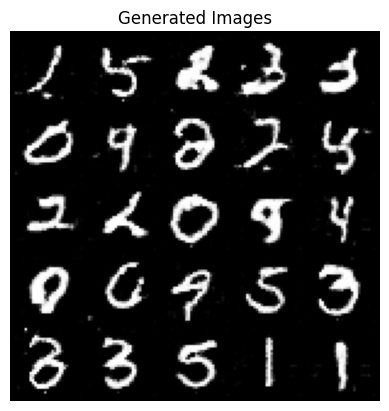

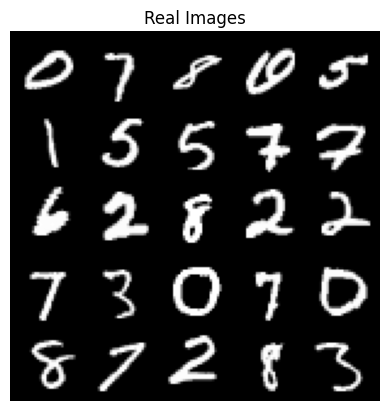

  0%|          | 0/469 [00:00<?, ?it/s]

Step 22500: Generator loss: 0.6967698631286621, discriminator loss: 0.6955174902677534


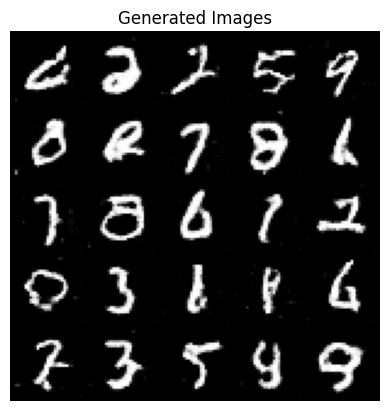

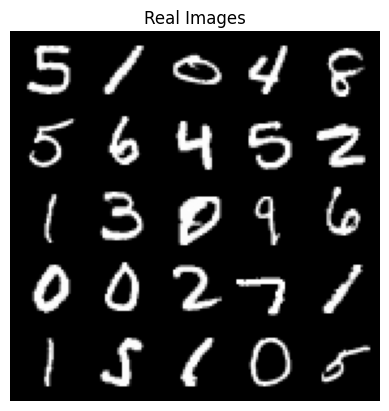

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 23000: Generator loss: 0.6974262921810147, discriminator loss: 0.6948751921653749


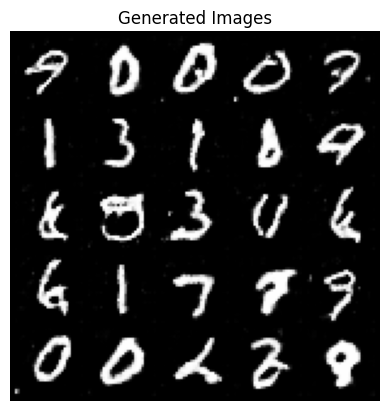

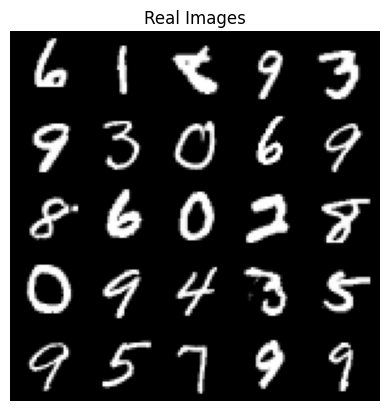

In [10]:
n_epochs = 50  # Number of training epochs
cur_step = 0  # Initialize step count
mean_generator_loss = 0  # Initialize mean generator loss
mean_discriminator_loss = 0  # Initialize mean discriminator loss

# Training loop
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)  # Move real images to the specified device (GPU or CPU)

        ## Update discriminator ##
        disc_opt.zero_grad()  # Zero out the gradients before backpropagation for the discriminator

        # Calculate discriminator loss
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)

        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()

        ## Update generator ##
        gen_opt.zero_grad()  # Zero out the gradients before backpropagation for the generator

        # Calculate generator loss
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)

        gen_loss.backward()
        gen_opt.step()  # Update generator's optimizer

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step
        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step

        # Visualization code - display generated and real images
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")

            # Generate fake images
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)

            # Display generated images
            show_tensor_images(fake, generated=True)

            # Display real images
            show_tensor_images(real)

            # Reset average losses for the next display
            mean_generator_loss = 0
            mean_discriminator_loss = 0

        cur_step += 1  # Update step count